# HW 12: The Big Challenge
## Abigail Kahler, HWRS 582

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = 150 m  

#### Topography
- Bottom of the domain is flat, bottom layer is 40m thick
- Middle layer is also flat, and 5 m thick
- Top layer elevation is provided in BASE_TOP_ELEV_CSV

#### Subsurface Properties: 
- Homogeneous within each of three layers 
- K top and bottom layers = 8.5 m/day in x, y and z.
- K middle layer = same as top and bottom for leftmost 20 columns
- K middle layer: 0.0001 m/day in z direction for rightmost 30 columns 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001   

#### Boundary Conditions: 
 - Right boundary for all layers is defined by a constant head of 70 m relative to the datum (located at bottom of domain).
 - Left, top, and bottom boundaries are no flow.
 
#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.001 m/m
- Streambed rough = 0.04
- Streambed width = 1 m
- Streambed K = 1.36 x horizontal K of top layer
- Streambed thickness = 1 m
- Stream bottom depth = 2 m #to set stream 1 m below ground surface
- Stage = .5 m

#### Well: 
 - Town pumping well
     - Located at row 21, column 38 screened in bottom layer
     - Pumping at a rate of 1500 m^3/day 
     - Some treated water returned to stream at column 25

  - Ag pumping well
    - Screen in top layer, row 12, columns 14
    - Pumping rate = crop water demand plus 20% for excess irrigation
      plus 30% for irrigation efficiency
    - Pumping rate wheat = 3000 m/day
    - Pumping rate pistachios = 4500 m/day
    - Pumping rate cotton = 6000 m/day
     

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from matplotlib import ticker

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [2]:
## model directory
moddir= "C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)

zbot = 0.     #bottom elevation
dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_xyz = 8.5   # m/day horizontal hydraulic conductivity in x, y, z 
K_mid_z = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 4e-5 #m/day

## Well
#pumping = -500 #m3/day  #given
#well_xy= [2500, 2500] #xy location of well 
#well_row = np.floor((nrow-1)-(well_xy[1]/dy)) #convert the y location to a row
#well_col=np.floor(well_xy[0]/dx-1) #convert the x location to a column
#well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
#print(well_loc)
#print(well_col)


## Boundary conditions
h_right = 70

## 4. Setup and run MODFLOW for three scenarios

#### 4.1 Model Run 1: No Town No Ag (NTNA)

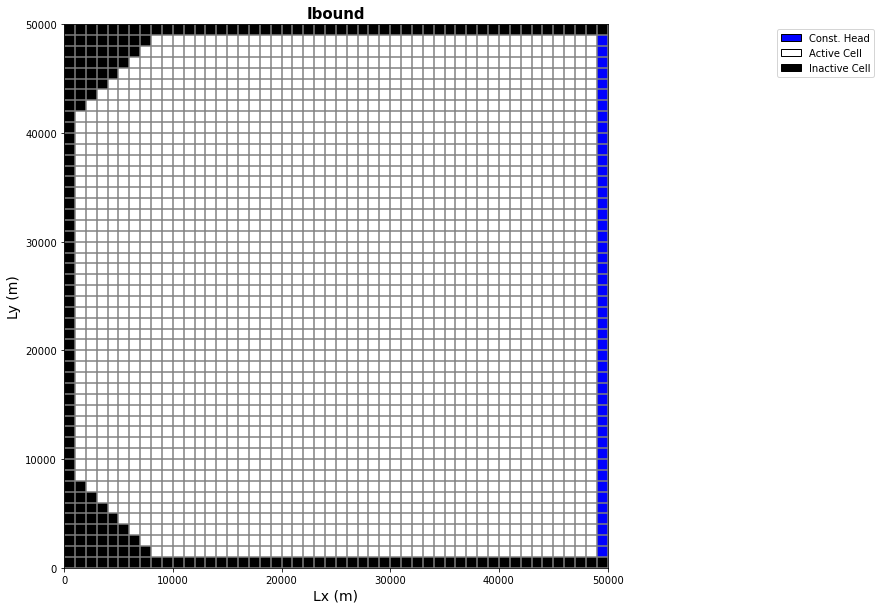

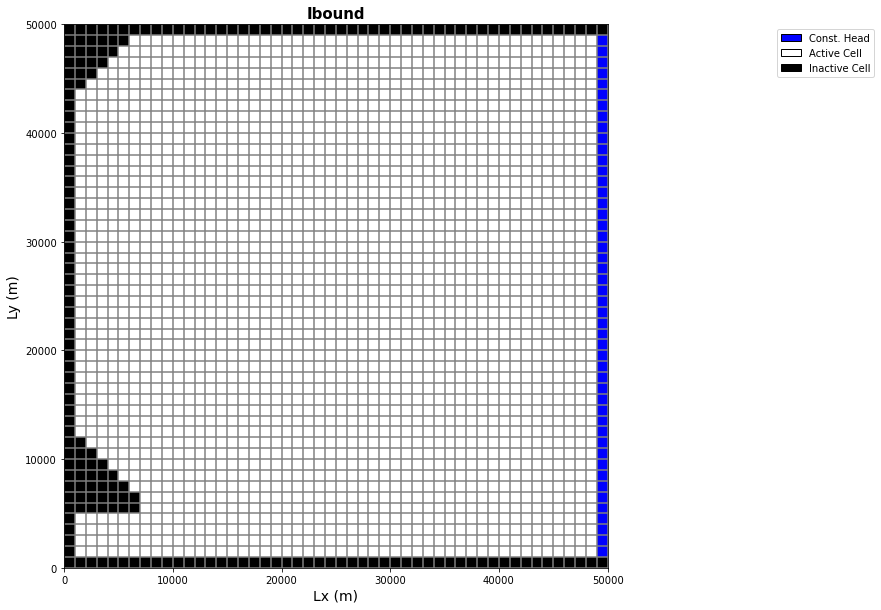

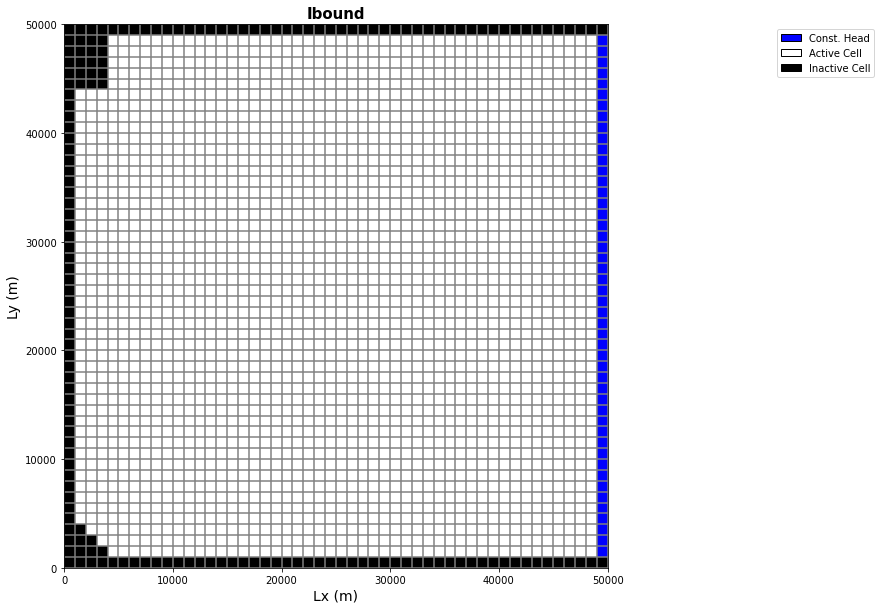

FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 11:07:45

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 11:07:45
 Elapsed run time:  0.072 Seconds

  Normal termination of simulation


In [8]:
#Initialize the model
modelname1 = "NTNA"    #No Town No Ag = steady state with no pumping from town well
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

## Make some changes to the parameters
#nlay_3lay=3  #two layers instead of 1
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[0,:,:] = 45   # bottom elevation of top layer (0) is 45 m 
botm[1,:,:] = 40   # bottom elevation of middle layer (1) is 40 m

## Make arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_xyz                   # assign the original value to the entire array
Kz[1,20:-1,:] = K_mid_z             # assign middle layer Kz in right half of domain

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_xyz                  # assign the original value to the entire array

#Create dis object
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
#ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
#ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1   #right boundary of constant head
ibound[:,:,0] = 0       #left boundary of no flow
ibound[:,0,:] = 0       #top boundary of no flow
ibound[:,-1,:] = 0      #bottom boundary of no flow

#Impermeable Bedrock
#Top layer - upper and lower left
#for i in range(0,6):
#    ibound[0:, i, 0:6-i] = 0
#for i in range(0,6):
#    ibound[0:, 44+i, 0:1+i] = 0

#Middle layer - upper and lower left
#for i in range(0,8):
#    ibound[1, i, 0:8-i] = 0

for i in range(0,9):
    if i <= 5:
        ibound[0, i, 0:5-1] = 0
        ibound[0, -1-i, 0:5-i] = 0
    elif 6 <= i <= 7:
        for j in range(0,7):
            ibound[1, j, 0:7-j] = 0
            ibound[1, -i-j, 0:7-j] = 0
    else:
        for k in range(0,9):
            ibound[2, k, 0:9-k] = 0
            ibound[2, -1-k, 0:9-k] = 0




#for i in range(0,8):               #adding this throws a termination error - non converge
#    ibound[1, 42+i, 0:1+i] = 0

#Bottom layer - upper and lower left
#for i in range(0,10):              #adding this throws a termination error - non converge
#    ibound[2, i, 0:10-i] = 0
#for i in range(0,10):              #adding this throws a termination error - non converge
#    ibound[2, 40+i, 0:1+i] = 0


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#------------------------------------------------------
#Model Map Layer 2
#plot grid and ibound
plt.figure(figsize = (10,10))
modelmap = flopy.plot.PlotMapView(model=m1, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)
#-------------------------------------------------------

#Model Map Layer 1
#plot grid and ibound
plt.figure(figsize = (10,10))
modelmap = flopy.plot.PlotMapView(model=m1, layer=1)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)
#-------------------------------------------------------

#Model Map Layer 0
#plot grid and ibound
plt.figure(figsize = (10,10))
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)
#-------------------------------------------------------



#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
#rech_zone[:,0:16] = recharge                    #recharge only occurs in 15 leftmost columns
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)     #create rch object

#Well
#well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
#well_1 = [i for i in well_loc] + [pumping]
#print(well_1)
#print("Well 1 [layer, row, column, flux]: \n", well_1)
#wel_spd = {0: [well_1]} #putting the well in the bottom layer
#wel = flopy.modflow.ModflowWel(model=m1, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

#write the inputs
m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

### Old HW 10 below here

#### 4.2 Model Run -- Well in Middle Layer

In [ ]:
#Initialize the model
modelname3_1 = "ThreeLayer_1"
m3_one = flopy.modflow.Modflow(modelname3_1, exe_name = moddir)

## Make some changes to the parameters
nlay_3lay=3  #two layers instead of 1
botm = np.zeros((nlay_3lay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 25.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 35.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3_one, nlay=nlay_3lay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay_3lay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay_3lay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m3_one, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3_one, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m3_one, rech=rech_zone, ipakcb=53)     #create rch object

#Well
well_loc = (1,well_row,well_col) #Well loc should be layer, row, column
well_1 = [i for i in well_loc] + [pumping]
print(well_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]} #putting the well in the middle layer
wel = flopy.modflow.ModflowWel(model=m3_one, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3_one, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3_one)

#write the inputs
m3_one.write_input()    

#Run the model 
success, mfoutput = m3_one.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

#### 4.3 Model Run -- Well in Bottom Layer

In [ ]:
#Initialize the model
modelname3_2 = "ThreeLayer_2"
m3_two = flopy.modflow.Modflow(modelname3_2, exe_name = moddir)

## Make some changes to the parameters
nlay_3lay=3  #two layers instead of 1
botm = np.zeros((nlay_3lay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 25.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 35.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3_two, nlay=nlay_3lay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay_3lay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay_3lay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m3_two, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3_two, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m3_two, rech=rech_zone, ipakcb=53)     #create rch object

#Well
well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
well_1 = [i for i in well_loc] + [pumping]
print(well_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]} #putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3_two, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3_two, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3_two)

#write the inputs
m3_two.write_input()    

#Run the model 
success, mfoutput = m3_two.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

#### 4.4 Model Run -- 3 layer, model adjusted to 1 layer run

In [ ]:
# #Initialize the model
# modelname3 = "ThreeLayer_1layer"
# m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

# ## Make some changes to the parameters
# nlay_3lay=3  #three layers instead of 1
# botm = np.zeros((nlay_3lay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
# botm[1,:,:] = 25.                  # bottom elevation of middle layer (1) is 25 m
# botm[0,:,:] = 35.                  # bottom elevation of top layer (0) is 35 m 

# ## Make a arrays for the K values
# Kz = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
# Kz[:,:,:] = K_vert                   # assign the original value to the entire array
# # Kz[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

# Kh = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
# Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
# # Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

# #Discretization - dis
# dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay_3lay, nrow=nrow, ncol=ncol, 
#                                delr=dx, delc=dy, top=ztop, botm=botm, 
#                                itmuni = 4, lenuni = 2, 
#                                nper=nper, steady=steady)


# # Boundary and initial conditions - bas
# #Define cell activity (IBOUND)
# ibound = np.ones((nlay_3lay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
# ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
# ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


# #setup initial heads as 1 everywhere except on the boundaries
# H_init = np.ones((nlay_3lay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
# H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
# H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
# bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

# #Layer properties - lpf
# lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
#                                vka=Kz, ss=Ss,
#                                sy=Sy,storagecoefficient=True, ipakcb=53) 

# #Recharge 
# rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
# rech_zone=rech_zone+recharge
# rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)     #create rch object

# #Well
# well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
# well_1 = [i for i in well_loc] + [pumping]
# print(well_1)
# print("Well 1 [layer, row, column, flux]: \n", well_1)
# wel_spd = {0: [well_1]} #putting the well in the bottom layer
# wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)

# #Output control - OC 
# spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
# oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

# #Numerical solver - pcg
# pcg = flopy.modflow.ModflowPcg(model=m3)

# #write the inputs
# m3.write_input()    

# #Run the model 
# success, mfoutput = m3.run_model(pause=False, report=True)
# if not success:
#     raise Exception('MODFLOW did not terminate normally.')

# 5. Plot the domains
### 5.1 Plan view of the domain

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m1)
ibound = mapview.plot_ibound()
wel = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

 fig = plt.figure(figsize=(15, 5))
 ax = fig.add_subplot(1, 1, 1)

 xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
 patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
 patches = xsect.plot_bc('WEL', color='red')
 linecollection = xsect.plot_grid(color='green')
 t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [ ]:
# Head - 1 layer model 
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

# #Head - 3 layer model, adjusted to 1 layer model
# headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
# times = headobj3.get_times()                 #returns a list of timesteps
# head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model, Run 1 
headobj3_0 = bf.HeadFile(modelname3_0+'.hds')    #reads the binary head file
times = headobj3_0.get_times()                 #returns a list of timesteps
head3_0 = headobj3_0.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model, Run 2 
headobj3_1 = bf.HeadFile(modelname3_1+'.hds')    #reads the binary head file
times = headobj3_1.get_times()                 #returns a list of timesteps
head3_1 = headobj3_1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model, Run 3 
headobj3_2 = bf.HeadFile(modelname3_2+'.hds')    #reads the binary head file
times = headobj3_2.get_times()                 #returns a list of timesteps
head3_2 = headobj3_2.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 

# #Water balance - 3 layer, adjusted to 1 layer
# budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
# print(budgobj3.get_unique_record_names())
# kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
# frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
# fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
# recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
# print(len(frf3))



#Water balance - 3 layer, Run 1
budgobj3_0 = bf.CellBudgetFile(modelname3_0+'.cbc')   #reads the cell budget file    
print(budgobj3_0.get_unique_record_names())
kstpkper_list3_0 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3_0 = budgobj3_0.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3_0 = budgobj3_0.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3_0 = budgobj3_0.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3_0))

#Water balance - 3 layer, Run 2
budgobj3_1 = bf.CellBudgetFile(modelname3_1+'.cbc')   #reads the cell budget file    
print(budgobj3_1.get_unique_record_names())
kstpkper_list3_1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3_1 = budgobj3_1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3_1 = budgobj3_1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3_1.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3_1))

#Water balance - 3 layer, Run 3
budgobj3_2 = bf.CellBudgetFile(modelname3_2+'.cbc')   #reads the cell budget file    
print(budgobj3_2.get_unique_record_names())
kstpkper_list3_2 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3_2 = budgobj3_2.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3_2 = budgobj3_2.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3_2.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3_2))


# 8. Plotting
### 8.1 One Layer Cross section plot

In [ ]:
#### 1 layered model 
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
# patches = xsect.plot_ibound(head=head1)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('1 Layer Model Row 25 Cross-Section')
# cb = plt.colorbar(pc, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)


### 8.2 Three Layer Cross Section Plots

In [ ]:
# Plot 1 and 3 layer Model Cross sections
fig = plt.figure(figsize=(15, 10))
ax0 = fig.add_subplot(2, 1, 1)

# # 1 Layer Model Run
# xsect0 = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect0.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
# patches = xsect0.plot_ibound(head=head1)
# # ax0.set_aspect('equal')
# ax0.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect0.plot_grid(color='black', lw=0.5)
# t = ax0.set_title('1 Layer Model Row 25 Cross-Section')
# fig.colorbar(pc, ax=ax0, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect0.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)

# ax1 = fig.add_subplot(2, 1, 2)
# # 3 Layer Model Run 2
# xsect1 = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc1 = xsect1.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
# patches = xsect1.plot_ibound(head=head3)
# ax1.set_ylabel('Depth (z) [m]', fontsize=10)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect1.plot_grid(color='black', lw=0.5)
# t = ax1.set_title('3 Layer Model Row 25 Cross-Section')
# fig.colorbar(pc1, ax=ax1, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect1.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


fig.tight_layout()

### 8.3 Three Layer Cross Section Plots

In [ ]:
# Plot 3 layer Model Cross sections
fig = plt.figure(figsize=(15, 10))
ax0 = fig.add_subplot(3, 1, 1)

# 3 Layer Model Run 1
xsect0 = flopy.plot.PlotCrossSection(model=m3_zero, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect0.plot_array(head3_0, masked_values=[999.], head=head3_0, alpha=0.5)
patches = xsect0.plot_ibound(head=head3_0)
# ax0.set_aspect('equal')
ax0.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect0.plot_grid(color='black', lw=0.5)
t = ax0.set_title('3 Layer Model Row 25 Cross-Section')
fig.colorbar(pc, ax=ax0, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect0.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

ax1 = fig.add_subplot(3, 1, 2)
# 3 Layer Model Run 2
xsect1 = flopy.plot.PlotCrossSection(model=m3_one, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc1 = xsect1.plot_array(head3_1, masked_values=[999.], head=head3_0, alpha=0.5)
patches = xsect1.plot_ibound(head=head3_1)
ax1.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect1.plot_grid(color='black', lw=0.5)
fig.colorbar(pc1, ax=ax1, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect1.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)

ax2 = fig.add_subplot(3, 1, 3)
# 3 Layer Model Run 3
xsect2 = flopy.plot.PlotCrossSection(model=m3_two, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc2 = xsect2.plot_array(head3_2, masked_values=[999.], head=head3_0, alpha=0.5)
patches = xsect2.plot_ibound(head=head3_2)
ax2.set_xlabel('Distance (x) [m]', fontsize=10)
ax2.set_ylabel('Depth (z) [m]', fontsize=10)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect2.plot_grid(color='black', lw=0.5)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect2.plot_surface(head3_0[0,:,:], masked_values=[999.], color='blue', lw=1)
fig.colorbar(pc2, ax=ax2, shrink=0.75)

fig.tight_layout()

# 9. Additional plots
### 9.1 Plot head transect

In [ ]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
# plt.plot(x,head1[0,int(well_row),:],marker='o', color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.plot(x,head3_0[0,int(well_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="3 layer top")
plt.plot(x,head3_0[1,int(well_row),:],marker='o', color='r', markersize=4, linestyle='--', label="3 layer middle")
plt.plot(x,head3_0[2,int(well_row),:],marker='o', color='green', markersize=4, linestyle='--', label="3 layer bottom")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

# plt.savefig('Head_Transect.png')

### 9.2 1 Layer Head Contours

In [ ]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

### 9.3 3 Layer head contours

In [ ]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3_zero, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3_0[0][0].min(),head3_0[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3_0, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3_0[0], fff3_0[0], head=head3_0) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   